 #  Georgia-Voting-Analysis
 > Election date 2020-11-03

* toc: true
* badges: true
* comments: true
* categories: [election]
    
---
    
  

## Setup


---
### Python imports
    
and defining a few utility functions

* whoami(): returns the name of the calling function
    
    
---
    


In [15]:
import os
import sys
import inspect
import warnings
import datetime
import time
import pdb
import xml
import re
import openpyxl
import collections
from collections import namedtuple
from collections import OrderedDict
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotnine as pn
from plotnine import ggplot, geom_point, geom_bar, aes, stat_smooth, facet_wrap
from tqdm import tqdm
import collections
import zipfile
import selenium
from selenium import webdriver
from selenium.webdriver.support.ui import Select

def whoami():
    return sys._getframe(1).f_code.co_name
now = datetime.datetime.now
now()

datetime.datetime(2020, 12, 29, 1, 9, 13, 436067)

    
---
### Selenium setup
#### for automating control of a browser, used mainly to automate downloads


---    
    


In [2]:
# set download directory
def chrome_options_download_dir(ddir):
    if not os.path.isdir(ddir):
        os.mkdir(ddir)
    prefs = {"download.default_directory" : os.path.abspath(ddir)}

    options = webdriver.ChromeOptions()
    options.add_experimental_option("prefs",prefs)
    options.add_argument("download.default_directory="+os.path.abspath(ddir))
    return options

    
---
## Results or vote count data
> by Contest, County, Choice, VoteType
    
### Data Source is  
https://results.enr.clarityelections.com/GA/105369/web.264614/#/summary   
    
Look on the right-hand side of the page for a "Reports" section.  There should be some download icons.
    If you click on those you can get the data.
    
 I chose to use the XML version of the data.  Maybe not the best choice but I seem to have made it work.
    
Data on election *results*, that is votes cast for each candidate.

Data is broken down by 
* Contest,  e.g. President, one of the Senate races and many more, 
* Choice. e.g. Trump vs Biden
* County
* Type of vote (Absentee, Early in-person, Election day in-person, Provisional)




### Other possible sources  for the senate race
    
www.nbcnews.com/politics/2020-special-elections/georgia-senate-results
    
https://results.enr.clarityelections.com/GA/105369/web.264614/#/detail/10000       
        
    
---



### ToDo: write some code to automaticly download the data file if it is not present locally

In [3]:

fpath = "./data/detailxml/detail.xml"
import xml.etree.ElementTree as et 
def node_msg(node, pref= '', tag=True, attribs=None):
    if attribs is None:
        attribs = []
    if isinstance(attribs, str):
        attribs = [attribs]
    msg = ""
    msg += "{0}{1}  tag: {2}".format(pref,node, node.tag)
    pref = pref+"  "    
    for at in attribs:
        atval = None
        if at in node.attrib.keys():
            atval = node.attrib[at]
        msg += "\n{0}{1} '{2}'".format(pref, at, atval)            
    return msg

In [4]:
CountyVoteTup = collections.namedtuple("CountyVoteTup",['CountyName', 'Votes'])
VoteTypeTup = collections.namedtuple("VoteTypeTup",    ['CountyName', 'Votes', 'VoteType'])    
ChoiceTup = collections.namedtuple("ChoiceTup",        ['CountyName', 'Votes', 'VoteType','Choice'])   
ContestTup = collections.namedtuple("ContestTup",      ['CountyName', 'Votes', 'VoteType','Choice', 'Contest'])  
def doCountyVote(node):
    county_name = node.attrib['name']
    votes = int(node.attrib['votes'])
    cv_tup = CountyVoteTup(county_name, votes)
    return cv_tup
def doVoteType(root_node, pref='', verbosity=0):
    if verbosity > 0:
        print(node_msg(root_node, pref=pref+'  ', attribs='text'))
    VoteTypeName = root_node.attrib['name']        
    counties = []
    votetype_tups = []
    for node in root_node:      
        if node.tag == "County":
            cv = doCountyVote(node)
            vt = VoteTypeTup(*cv, VoteTypeName)
            votetype_tups.append(vt)
            counties.append(cv)
    res = pd.DataFrame(counties)
    res.set_index("CountyName", inplace=True)
    res.rename(columns={"Votes":VoteTypeName}, inplace=True)
    return (res, votetype_tups)
def doChoice(root_node, pref='', verbosity=0):
    if verbosity > 0:
        print(node_msg(root_node, pref=pref+'  ', attribs='text'))   
    ChoiceText = root_node.attrib['text']         
    res = None
    choice_tups = []
    for node in root_node:
        if node.tag == "VoteType":
            df, vts = doVoteType(node)
            for vt in vts:
                choice = ChoiceTup(*vt, ChoiceText)
                choice_tups.append(choice)
            if res is None:
                res = df
            else:
                res = res.join(df, how="left")             
    res['Total'] = res.sum(axis=1)     
    res.columns = pd.MultiIndex.from_product([[ChoiceText], res.columns])   
    return res, choice_tups
def doContest(root_node, pref='', verbosity=0):
    if verbosity > 0:
        print(node_msg(root_node, pref=pref+'  ', attribs='text'))       
    res = None
    ContestText = root_node.attrib['text']     
    contest_tups = []
    for node in root_node:
        if node.tag == "Choice":
            choice, tups = doChoice(node)              
            for tup in tups:
                contest_tup = ContestTup(*tup, ContestText)
                contest_tups.append(contest_tup)
            if res is None:
                res = choice
            else:
                res = res.join(choice, how='left')
    return (res, contest_tups)

In [ ]:
xtree = et.parse(fpath)
senate_races = []
xroot = xtree.getroot()
tups = []
contests = {}
for i, node in enumerate(tqdm(xroot)): 
    if node.tag == 'Contest':
        if 'text' in node.attrib.keys():
            if 'US Senate'  in node.attrib['text'] or \
                'President' in node.attrib['text'] :
                contest = node.attrib['text']
                res, contest_tups = doContest(node, pref='')
                tups.extend(contest_tups)
                print(contest)
                contests[contest] = res
contests.keys()
contestsdf = pd.DataFrame(tups)
contestsdf['CountyName'] = contestsdf['CountyName'].apply(lambda x: x.upper())

In [12]:
print("Vote counts for President and the 2 Senate races")
contestsdf.groupby(by="Contest").sum().sort_values(by="Votes")

Vote counts for President and the 2 Senate races


,Votes
Contest,
US Senate (Loeffler) - Special,4914361
US Senate (Perdue),4952175
President of the United States,4998482


### Sum over all counties

In [16]:
grp_contests = contestsdf.groupby(by=['VoteType','Choice', 'Contest']).sum()
grp_contests.sort_values(by=['Contest', 'VoteType','Choice'],inplace=True)
grp_contests.reset_index(inplace=True)
grp_contests.sort_values(by="Votes", ascending=False, inplace=True)
contests = grp_contests['Contest'].unique()
vote_types = grp_contests["VoteType"].unique()

In [ ]:
x = widedf[['CountyName', 'Both']].groupby(by="CountyName").sum()
x.sort_values(by="Both", inplace=True)
county_cat = pd.Categorical(x.index, categories=x.index)
county_cat
cat_df = pd.DataFrame({"CountyName": x.index, "CountyCat": county_cat})
cat_df
z = widedf.merge(cat_df, on="CountyName")
z

In [32]:
df = contestsdf.loc[contestsdf["Contest"].str.contains("President")]
df.head()

,CountyName,Votes,VoteType,Choice,Contest
0,APPLING,1753,Election Day Votes,Donald J. Trump (I) (Rep),President of the United States
1,ATKINSON,716,Election Day Votes,Donald J. Trump (I) (Rep),President of the United States
2,BACON,431,Election Day Votes,Donald J. Trump (I) (Rep),President of the United States
3,BAKER,291,Election Day Votes,Donald J. Trump (I) (Rep),President of the United States
4,BALDWIN,1873,Election Day Votes,Donald J. Trump (I) (Rep),President of the United States


In [ ]:
x = df[['CountyName', 'Votes']].groupby(by="CountyName").sum()
x.sort_values(by="Votes", inplace=True)
county_cat = pd.Categorical(x.index, categories=x.index)
county_cat
cat_df = pd.DataFrame({"CountyName": x.index, "CountyCat": county_cat})
cat_df
z = df.merge(cat_df, on="CountyName")
z

In [81]:
N = 16
z.sort_values(by="Votes", inplace=True, ascending=False)

bigN = list(z[["CountyName","Votes"]].groupby(by="CountyName").sum().sort_values(by="Votes").tail(15).index)
bigNstr = "|".join(bigN)
big2 = ["FULTON", "DEKALB"]
big2str = "|".join(big2)

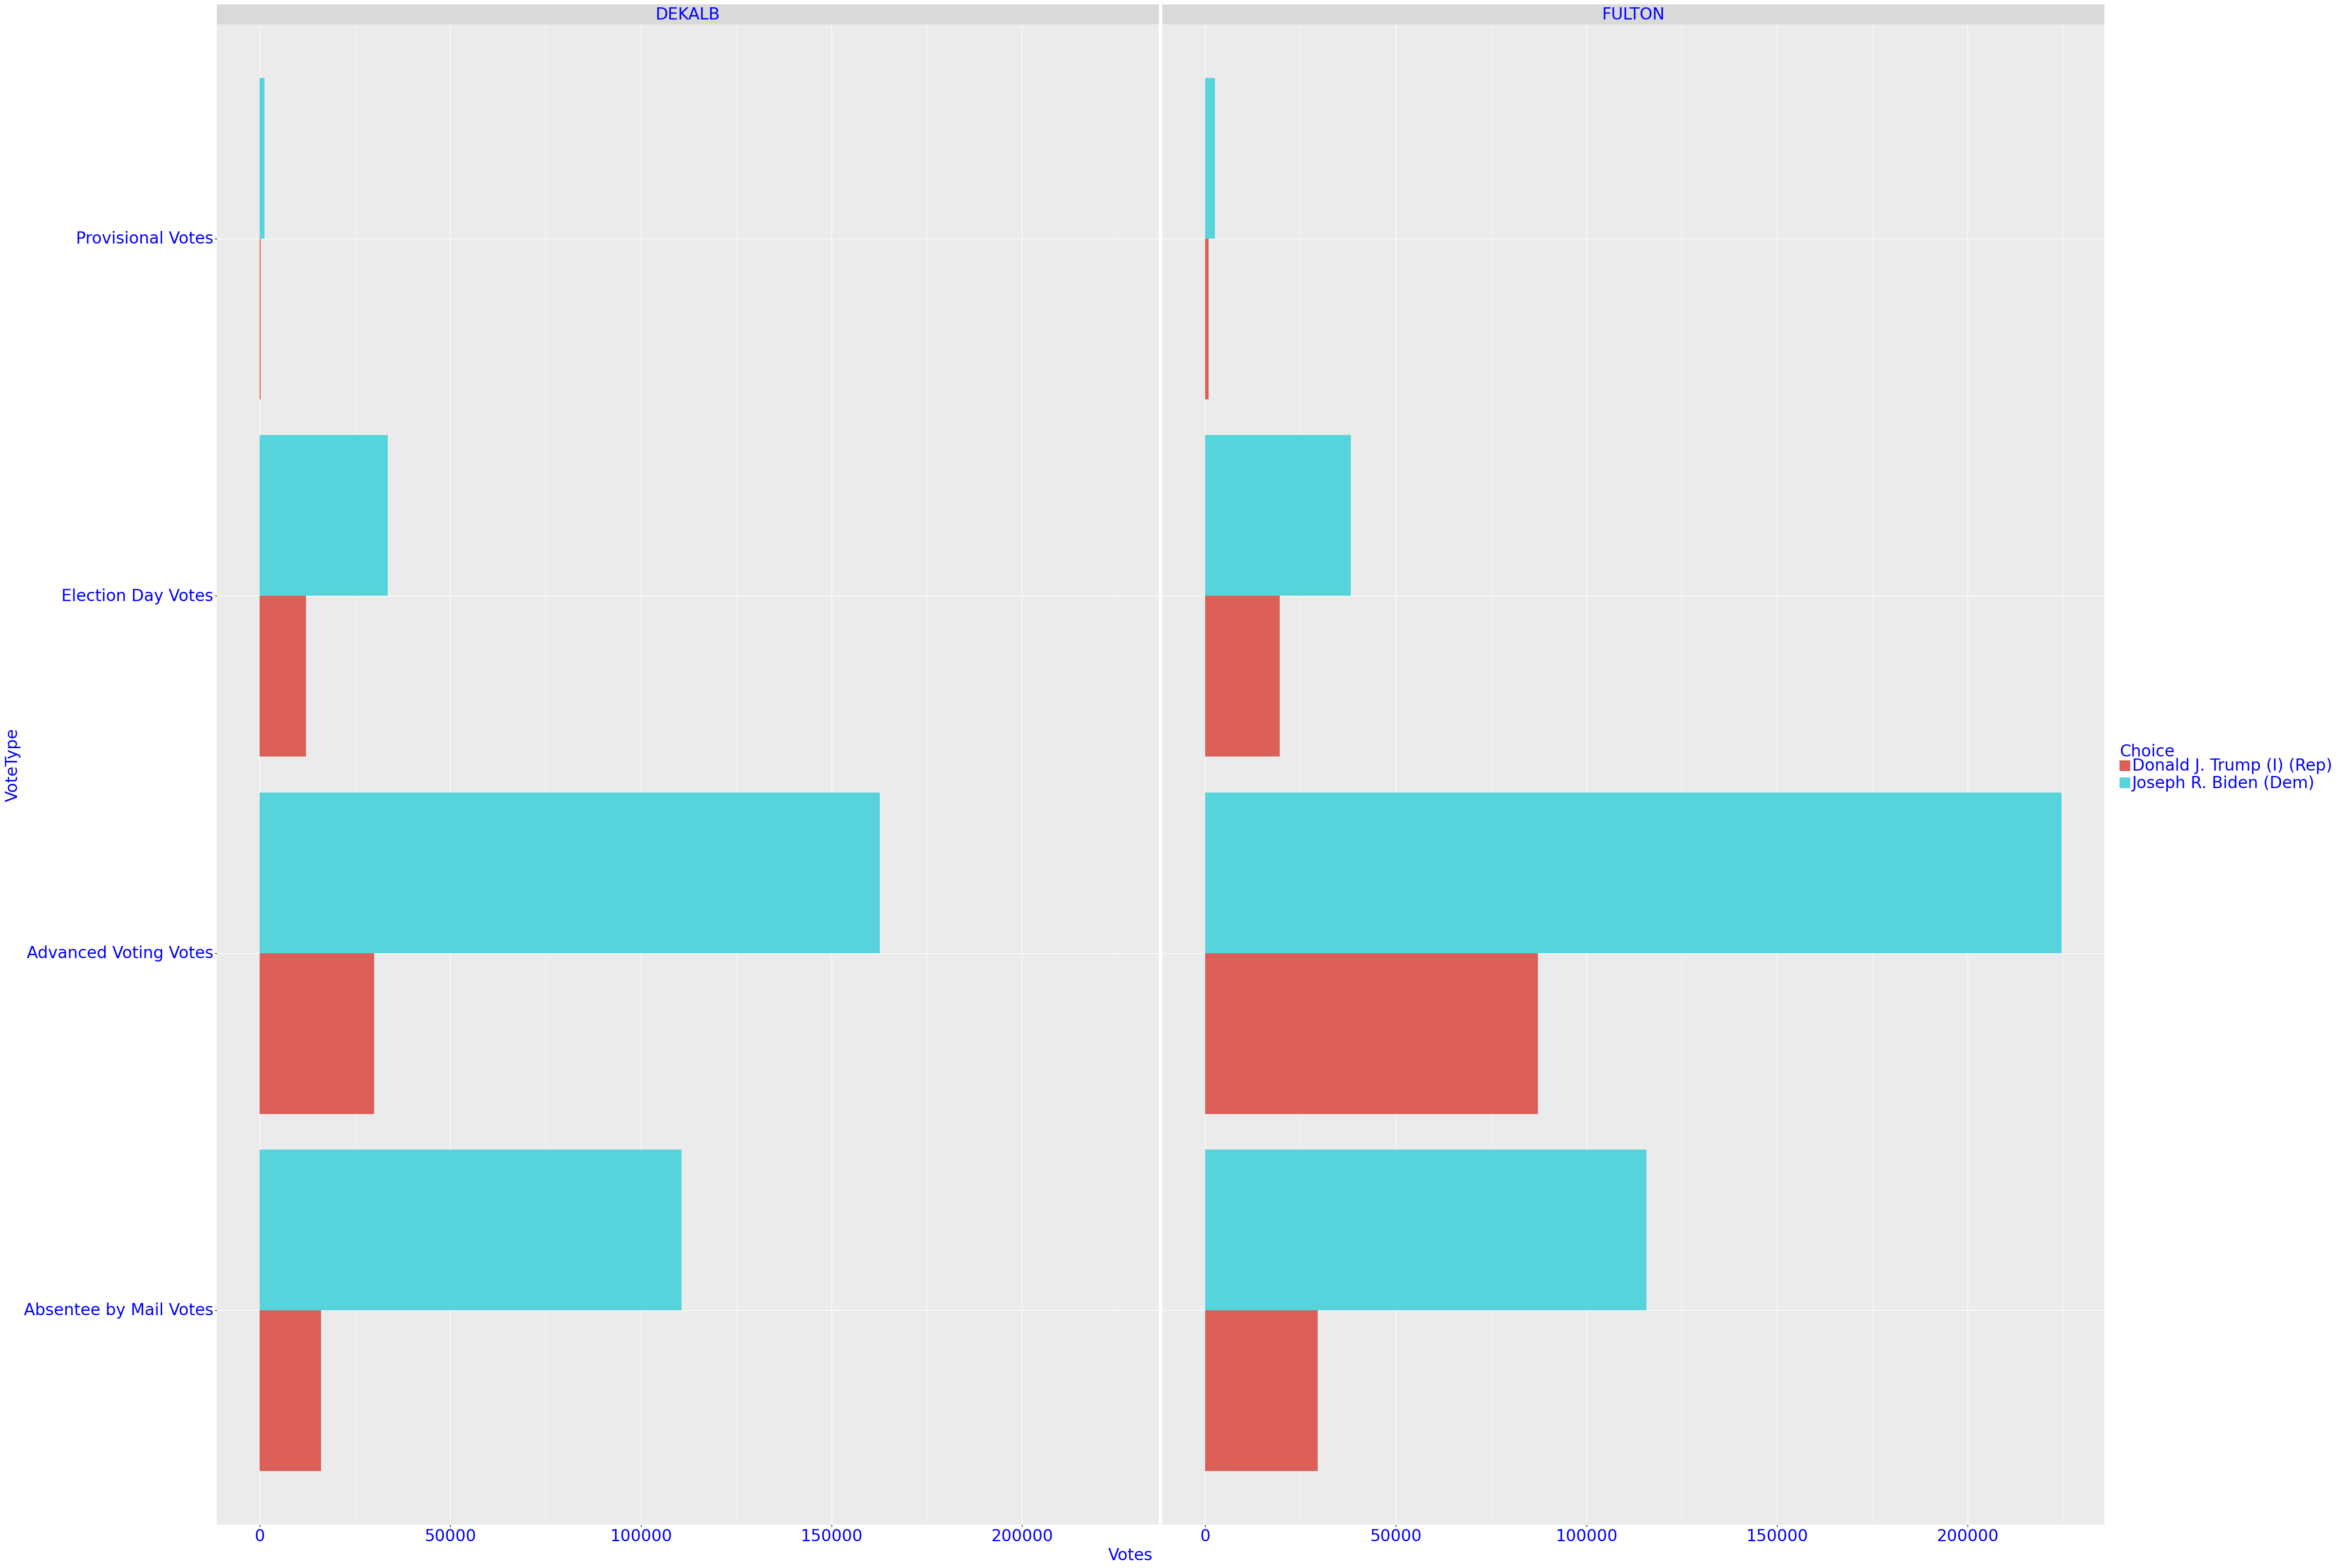

<ggplot: (117533194825)>

In [82]:
pn.options.figure_size = (50, 40)
z.sort_values(by="Votes", ascending=False, inplace=True)

big = z.loc[z["CountyName"].str.contains(big2str)]
big = big.loc[big["Choice"].str.contains("Trump|Biden")]
plt = ggplot(big) \
 + pn.coord_flip()\
  + geom_bar(aes(x='VoteType', y='Votes',fill="Choice"), stat='identity', position="dodge")\
  + facet_wrap("~CountyCat")\
 + pn.theme(
    text=pn.element_text(color="blue", size=24))
plt

In [8]:
grp_contests.loc[grp_contests['Contest'].str.contains('President'),]
grp_contests.sort_values(by="Votes", inplace=True)
grp_contests.loc[grp_contests['Contest'].str.contains('Loeffler'),].tail(10)

,VoteType,Choice,Contest,Votes
37,Advanced Voting Votes,Deborah Jackson (Dem),US Senate (Loeffler) - Special,173820
19,Absentee by Mail Votes,Doug Collins (Rep),US Senate (Loeffler) - Special,185300
68,Election Day Votes,Raphael Warnock (Dem),US Senate (Loeffler) - Special,205110
59,Election Day Votes,Doug Collins (Rep),US Senate (Loeffler) - Special,211902
25,Absentee by Mail Votes,Kelly Loeffler (I) (Rep),US Senate (Loeffler) - Special,249090
65,Election Day Votes,Kelly Loeffler (I) (Rep),US Senate (Loeffler) - Special,298209
39,Advanced Voting Votes,Doug Collins (Rep),US Senate (Loeffler) - Special,581871
28,Absentee by Mail Votes,Raphael Warnock (Dem),US Senate (Loeffler) - Special,601522
45,Advanced Voting Votes,Kelly Loeffler (I) (Rep),US Senate (Loeffler) - Special,724577
48,Advanced Voting Votes,Raphael Warnock (Dem),US Senate (Loeffler) - Special,807005


In [9]:
presdf = contestsdf[contestsdf['Contest'].str.contains("President")]
presByCounty = presdf[["CountyName", "Votes"]].groupby("CountyName").sum()
presByCounty.sort_values(by="Votes", ascending=False, inplace=True)
presByCounty.head(4)

,Votes
CountyName,
FULTON,524659
GWINNETT,413865
COBB,393746
DEKALB,370804


In [10]:
loefflerdf = contestsdf[contestsdf['Contest'].str.contains("Loeffler")]
purduedf = contestsdf[contestsdf['Contest'].str.contains("Loeffler")]
if True:
    gdf = presdf[['VoteType', 'Votes', 'Contest']].groupby('VoteType').sum() 
    gdf["Pct"] = 100*np.round(gdf / gdf.sum(),3)
    print("Votes counted by Vote Type")
    print(gdf)
    print("------")
    print("Total votes counted (millions): {0}".format(gdf["Votes"].sum()/10.0**6))

Votes counted by Vote Type
                          Votes   Pct
VoteType                             
Absentee by Mail Votes  1316943  26.3
Advanced Voting Votes   2694879  53.9
Election Day Votes       975540  19.5
Provisional Votes         11120   0.2
------
Total votes counted (millions): 4.998482


In [11]:
votesByCounty = contestsdf[["CountyName", "Votes"]].groupby("CountyName").sum()
votesByCounty.sort_values(by="Votes", ascending=False, inplace=True)
votesByCounty.head(4)

,Votes
CountyName,
FULTON,1563044
GWINNETT,1227786
COBB,1173481
DEKALB,1105580


   
---
    
## Registered voters by County-Age-Race
    
    
### Source is  
https://sos.ga.gov/index.php/Elections/voter_registration_statistics    
    
 I choose the most granular, that is, by
* County, 
* Age, 
* Race
    
Right now not doing anything with the Age or Race data, just aggregating to County.    
    

    
---
    


### To Do: write code to automaticly download the data if not present locally

In [30]:
dpath = "./data/"
voterfile = "Active_Voters_by_Race_Gender_and_Age_as_of_November_1_2020.xlsx"
voterpath = os.path.join(dpath, voterfile)
if not os.path.isdir(dpath):
    warnings.warn("{0} is not a directory".format(dpath))
if not os.path.isfile(voterpath):
    warnings.warn("No file {0} in dir {1}".format(voterfile, dpath))
with open(voterpath) as vp:
    racedf = pd.read_excel(voterpath, nrows=7, engine='openpyxl').iloc[:,:2]
    racedf.columns = ["RaceCode", "RaceDescription"]
    racedf["RaceCode"] = racedf["RaceCode"].apply(lambda x: x[:-2])
    racedf.set_index("RaceCode", inplace=True)
    race = racedf.squeeze()
    race_dict = race.to_dict()
    print(race_dict)

{'AI': 'AMERICAN INDIAN OR ALASKAN NATIVE', 'AP': 'ASIAN OR PACIFIC ISLANDER', 'BH': 'BLACK NOT OF HISPANIC ORIGIN', 'HP': 'HISPANIC', 'WH': 'WHITE NOT OF HISPANIC ORIGIN', 'OT': 'OTHER', 'UK': 'UNKNOWN'}


In [31]:
votersdf = pd.read_excel(voterpath, skiprows=8, engine='openpyxl')
if votersdf.columns[-1] != "TOTAL VOTERS":
    votersdf = votersdf.iloc[:,:-1]
colnames = [re.sub("\s+", "-", c.strip()) for c in votersdf.columns]
votersdf.columns = colnames

votersdf.drop('COUNTY-ID', axis=1, inplace=True)    
votersdf = votersdf.loc[votersdf["COUNTY-NAME"].notna()]
colname_parts = [c.split("-") for c in votersdf.columns]
newnames = []

for parts in colname_parts:
    newparts = parts
    if parts[0]  in race_dict.keys():
        newparts = [race_dict[parts[0]].split(" ")[0]] + parts[1:]
    newnames.append("-".join(newparts))
votersdf.columns = newnames
votersdf.rename(columns={"COUNTY-NAME":"CountyName", 
                        'TOTAL-VOTERS':'TotalVoters'}, inplace=True)
votersdf['CountyName'] = votersdf['CountyName'].apply(lambda x: x.upper())
print("{0} rows {1} cols".format(*votersdf.shape))
votersdf.head(2)

1594 rows 24 cols


,CountyName,VOTER-AGE-RANGE,AMERICAN-MALE-VOTERS,AMERICAN-FEMALE-VOTERS,AMERICAN-UNKNOWN-VOTERS,ASIAN-MALE-VOTERS,ASIAN-FEMALE-VOTERS,ASIAN-UNKNOWN-VOTERS,BLACK-MALE-VOTERS,BLACK-FEMALE-VOTERS,...,WHITE-MALE-VOTERS,WHITE-FEMALE-VOTERS,WHITE-UNKNOWN-VOTERS,OTHER-MALE-VOTERS,OTHER-FEMALE-VOTERS,OTHER-UNKNOWN-VOTERS,UNKNOWN-MALE-VOTERS,UNKNOWN-FEMALE-VOTERS,UNKNOWN-UNKNOWN-VOTERS,TotalVoters
0,APPLING,18-24,2,1,0,3,5,0,120,110,...,436,429,1,5,19,0,95,60,2,1374
1,APPLING,25-29,0,0,0,4,1,0,81,89,...,282,298,1,3,7,0,38,30,0,866


In [14]:
gcols = ["CountyName"]
votersByCounty = votersdf[["CountyName", 'TotalVoters' ]].groupby(by=gcols).sum()
votersByCounty.sort_values(by="TotalVoters", ascending=False, inplace=True)

TotalVoters    int64
dtype: object

    
---
    
# Combining Voters and Votes by County
    
---
    
</span>

In [29]:
presCombo = presByCounty.join(votersByCounty)
presCombo["PctVoted"] = np.round(100*presCombo['Votes'] / presCombo['TotalVoters'],3)
presCombo.sort_values(by="PctVoted", inplace=True, ascending=False)
print("Counties with highest percentage turnout\n{0}".format(presCombo.head(4)))
print("\n-----\n")
presCombo.sort_values(by="Votes", ascending=False, inplace=True)
totalVotes = presCombo['Votes'].sum()
presCombo['PctofVoters'] = np.round(100*presCombo['Votes'] / totalVotes, 1)
presCombo['CumPctofVoters'] = np.round(100*presCombo['Votes'].cumsum() / totalVotes, 1)
print("Counties with most Votes\n{0}".format(presCombo.head(12)))

Counties with highest percentage turnout
            Votes  TotalVoters  PctVoted
CountyName                              
OCONEE      25168        30051    83.751
WEBSTER      1390         1713    81.144
UNION       15560        19235    80.894
GREENE      11247        14197    79.221

-----

Counties with most Votes
             Votes  TotalVoters  PctVoted  PctofVoters  CumPctofVoters
CountyName                                                            
FULTON      524659       808742    64.873         10.5            10.5
GWINNETT    413865       582917    70.999          8.3            18.8
COBB        393746       537659    73.233          7.9            26.7
DEKALB      370804       547802    67.689          7.4            34.1
CHEROKEE    144830       190605    75.984          2.9            37.0
CHATHAM     133420       202999    65.724          2.7            39.6
FORSYTH     129305       164279    78.711          2.6            42.2
HENRY       122742       172241    71.262

---
    
## Individual Voters
    
### Source is  
https://elections.sos.ga.gov/Elections/voterhistory.do


According to the site this is data on "*credit for voting by qualified electors*"  

I *believe* there is a record for each registered voter.
    

According to the *Voter History File Layout* at the bottom, the fields in each line are as follows:  
1	County Number: 3 characters
2	Registration Number: 8 characters
3	Election Date: 8  characters
4	Election Type: 3 characters, see the web page
5	Party: 2 characters
6	Absentee: 1 character  ('Y' or 'N')
7	Provisional: 1 character  ('Y' or 'N')
8	Supplemental: 1 character  ('Y' of 'N')
    
I'm not sure what "Registration Number" is but I am guessing it is tied to a specific voter.
The documntation for "Election Type" lists the following possibilities:  
<ul stype="list-style-type: none;  margin-left: 40px;">
<li>001 GENERAL PRIMARY  
<li>002 GENERAL PRIMARY RUN-OFF  
<li>003 GENERAL  
<li>004 GENERAL ELECTION RUNOFF  
<li>005 SPECIAL ELECTION  
<li>006 SPECIAL RUNOFF  
<li>007 NON- PARTISAN  
<li>008 SPECIAL/NON-PARTISAN  
<li>009 RECALL  
<li>010 PPP  
<li>SPECIAL PRIMARY RUNOFF  
<li>SPECIAL PRIMARY    
</ul>

The documentation gives the following possibilities for "Party"   
- D Democratic  
- R Republican  
- NP Non-Partisan 
 
    
    

---
    


In [32]:
def get_individual_voter_reg_files(download_dir, verbosity=0):
    if verbosity > 0:
        print("{0} download_dir= {1}, <{2}>".format(whoami(), download_dir,
                                                   datetime.datetime.now()))
    options = chrome_options_download_dir(download_dir)    
    chromedriver_path = os.path.join('chromedriver.exe')
    driver = webdriver.Chrome(executable_path=chromedriver_path, options=options)
    url = "https://elections.sos.ga.gov/Elections/voterhistory.do"
    driver.get(url)
    # find year selector and select 2020
    year_select = Select(driver.find_element_by_id("nbElecYear"))
    year_select.select_by_value("2020")
    # find the election selector and select 11/03/2020
    elec_select = Select(driver.find_element_by_id("idElection"))
    elec_select.select_by_visible_text("11/03/2020 - NOVEMBER 3, 2020 GENERAL/SPECIAL ELECTION")
    # find the elecCat selector and select StaeWide
    cat_select = Select(driver.find_element_by_id("cdElecCat"))
    cat_select.select_by_visible_text("STATE WIDE")
    time.sleep(0.5)
    # click on button to download 2020 file
    if verbosity > 0:
        print("  downloading 2020 file")
    driver.find_element_by_partial_link_text("2020").click()
    time.sleep(0.5)
    fname = "2020.zip"
    max_wait_secs = 9
    file_there = False
    start_dt = datetime.datetime.now()
    if verbosity > 0:
        print("looking for file {0} in {1}".format(fname, download_dir))
    while not file_there:
        files = os.listdir(download_dir)
        if fname in files:
            if verbosity > 0:
                print("  Found it '{0}'".format(fname))
            file_there = True
            break
        cur_dt = datetime.datetime.now()
        if verbosity > 0:
            print("  Not there yet <{0}>".format(cur_dt))
        time.sleep(1)
        if (cur_dt - start_dt).total_seconds() > max_wait_secs:
            if verbosity > 0:
                print("{0} not in {1}, can't wait any longer".format(fname, download_dir))
            break
    if file_there:
        if verbosity > 0:
            print(" Unzipping {0} to {1}".format(fname, download_dir))
        fpath = os.path.join(download_dir, fname)
        zpath = os.path.join(download_dir, fname.split(".")[0])
        with zipfile.ZipFile(fpath, 'r') as zip_ref:
            zip_ref.extractall(zpath)    
    #click on button to download County files
    if verbosity > 0:
        print("  downloading county file")    
    driver.find_element_by_partial_link_text("County Number").click() 
    time.sleep(1)
    if verbosity > 0:
        print("Done {0}".format(datetime.datetime.now()))
    
    

In [33]:
data_path = "./data"
elems = os.listdir(data_path)
if "2020" not in elems:
    get_individual_voter_reg_files(download_dir=data_path, verbosity=1)
data_path = "./data/2020"    
if not os.path.isdir(data_path):
    warnings.warn("2020 data not there, Somthing wrong")
else:
    elems_2020 = os.listdir(data_path)
    fname = "2020.TXT"
    fpath = os.path.join(data_path, fname)
    if fname not in elems_2020:
        warnings.warn("{0} not found".format(fname))
    elif not os.path.isfile(fpath):
        warnings.warn("{0} not a file".format(fname))
    else:
        fpath = os.path.join(data_path, fname)
        print("Detailed registerd voter data for 2020 in the file '{0}' in the directory {1}".format(fname, dpath))

Detailed registerd voter data for 2020 in the file '2020.TXT' in the directory ./data/


In [35]:
# Read in the data into a list of text lines
with open(fpath, mode='r') as fp:
    txt = fp.read()
voter_lines = txt.split('\n')
minlen = min([len(l) for l in voter_lines])
maxlen = max([len(l) for l in voter_lines])
print("{0} had {1} lines, minlen {2}, maxlen {3}".format(fname, len(voter_lines), minlen, maxlen))

2020.TXT had 8454089 lines, minlen 0, maxlen 27


In [36]:
# Parse into a list of named tuples
def parse_fields(lines, field_dict):       
    """ parse the fields of a line
    This was my original and was slow.
    I changed to the numpy slice version below.
    """
    VoterRec = namedtuple("VoterRec", field_dict.keys() )
    expected_len = sum(field_dict.values())    
    tups = []    
    def parse_fields(line, field_dict):
        start = 0
        data = {}
        for k in field_dict.keys():
            width = field_dict[k]
            elem = line[start:(start+width)]
            data[k] = elem
            start += width
        return data
    for i, line in enumerate(tqdm(lines)):
        if len(line) != expected_len:
            msg = "{0} len={1}, line={2}".format(i, len(line), line)
            continue
        tup = parse_fields(line, field_dict)
        vr = VoterRec(**tup)
        tups .append(vr)
    return tups

def parse_slices(lines, field_dict):
    # parse slices
    VoterRec = namedtuple("VoterRec", field_dict.keys() )
    expected_len = sum(field_dict.values())    
    tups = []
    def parse_slices(line, slices):
        return [line[s] for s in slices]      
    widths = field_dict.values()
    idx = np.cumsum([0] + list(widths))
    slices = [slice(i, j) for (i, j) in zip(idx[:-1], idx[1:])]    
    for i, line in enumerate(tqdm(lines)):
        if len(line) != expected_len:
            msg = "{0} len={1}, line={2}".format(i, len(line), line)
            continue
        data = parse_slices(line, slices)
        vr = VoterRec(*data)
        tups .append(vr) 
    return tups
    
def parse_voter_lines(lines=None, which_parser="slices"):
    field_dict = {'county_num':3,
                'registration_num':8,
                'election_date':8,
                'election_type': 3,
                'party': 2,
                'absentee':1,
                'provisional':1,
                'supplemental':1}
    #field_widths = field_dict.values()
    #field_names =  field_dict.keys()
    if which_parser == "slices":
        tups = parse_slices(lines, field_dict)
    elif which_parser == "fields":
        tups = parse_slices(lines, field_dict)
    else:
        raise (ValueError("Invalid input for 'which_parser'= {0}, should be either 'slices' or 'fields'".format(which_parser)))
    return tups

voter_tups= parse_voter_lines(lines=voter_lines, which_parser='slices')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8454089/8454089 [00:19<00:00, 425871.16it/s]


In [47]:
# create a pandas DataFrame from the tuples
regdf = pd.DataFrame(voter_tups)
print("DataFrame rows: {0}".format(regdf.shape[0]))
print(regdf.head(2).to_string(index=False))

DataFrame rows: 8454088
county_num registration_num election_date election_type party absentee provisional supplemental
       067         02788924      20200324           005              N           N            N
       067         05761105      20200324           005              N           N            N


In [48]:
ElectionTypeDict = {
'001':'GENERAL PRIMARY',
'002':'GENERAL PRIMARY RUN-OFF',
'003':'GENERAL',
'004':'GENERAL ELECTION RUNOFF',
'005':'SPECIAL ELECTION',
'006':'SPECIAL RUNOFF',
'007':'NON- PARTISAN',
'008':'SPECIAL/NON-PARTISAN',
'009':'RECALL',
'010':'PPP'
}
#SPECIAL PRIMARY RUNOFF
#SPECIAL PRIMARY
etypedf = pd.DataFrame.from_dict(data=ElectionTypeDict, orient="index", columns=['Description']).reset_index()
etypedf.columns = ['election_type', 'description']
print(etypedf.to_string(index=False))

election_type              description
          001          GENERAL PRIMARY
          002  GENERAL PRIMARY RUN-OFF
          003                  GENERAL
          004  GENERAL ELECTION RUNOFF
          005         SPECIAL ELECTION
          006           SPECIAL RUNOFF
          007            NON- PARTISAN
          008     SPECIAL/NON-PARTISAN
          009                   RECALL
          010                      PPP


In [49]:
gcols = ['election_date', 'election_type']
allcols = gcols + ['party']
counts = regdf[allcols].groupby(by=gcols).count().reset_index()
counts.columns = gcols + ['count']
typecount = counts.merge(etypedf, on='election_type')
typecount.sort_values(by="election_date", ascending=True, inplace=True)
print("# of records for each election types\n Sorted by 'election_date'")
print(typecount.to_string(index=False))

# of records for each election types
 Sorted by 'election_date'
election_date election_type    count              description
     20200128           005     4881         SPECIAL ELECTION
     20200204           005    11940         SPECIAL ELECTION
     20200303           006     3705           SPECIAL RUNOFF
     20200324           005      310         SPECIAL ELECTION
     20200324           010   292266                      PPP
     20200519           005        2         SPECIAL ELECTION
     20200609           005      280         SPECIAL ELECTION
     20200609           001  2362615          GENERAL PRIMARY
     20200811           002   673194  GENERAL PRIMARY RUN-OFF
     20200929           005    34812         SPECIAL ELECTION
     20201103           005     3604         SPECIAL ELECTION
     20201103           003  5007390                  GENERAL
     20201201           006    24773           SPECIAL RUNOFF
     20201201           004    34248  GENERAL ELECTION RUNOFF
     2

## Questions and comments
What are these elections *after* 2020-11-03?  
Some are of a different type, but why are there 15 votes listed for the *General* election on 2020-12-04?  

Worth writing to the GA Sec of State to ask about.

In any case, I am going to only analyze the data for
* election_type == '003' , i.e. GENERAL  
* election_date= 20201103

In [50]:
etype = '003'
edate= '20201103'
gendf = regdf.loc[np.logical_and(regdf['election_type'] == etype,
                                  regdf['election_date'] == edate)]

print("{0} rows for election type = '{1}' and election date= '{2}'".format(gendf.shape[0], etype, edate))
print(gendf.head(2).to_string(index=False))

5007390 rows for election type = '003' and election date= '20201103'
county_num registration_num election_date election_type party absentee provisional supplemental
       019         00591608      20201103           003              Y           N            N
       027         00430264      20201103           003              Y           N            N


In [52]:
cnames = ['absentee', 'provisional', 'supplemental']
print("count of votes by type")
print(gendf[cnames].value_counts())
print("\nPercentage of votes by type")
print(np.round(100*gendf[cnames].value_counts(normalize=True), 1))

count of votes by type
absentee  provisional  supplemental
Y         N            N               4018954
N         N            N                981654
          Y            N                  6476
          N            Y                   165
Y         Y            N                   124
N         Y            Y                    12
Y         Y            Y                     4
          N            Y                     1
dtype: int64

Percentage of votes by type
absentee  provisional  supplemental
Y         N            N               80.3
N         N            N               19.6
          Y            N                0.1
          N            Y                0.0
Y         Y            N                0.0
N         Y            Y                0.0
Y         Y            Y                0.0
          N            Y                0.0
dtype: float64


## More Questions and comments
From the table above we see that 
* over 4 million votes were "absentee"
* 981,654 votes cast were not "absentee", "provisional" or "supplemental", so what were these?  Are these in-person on the day of the election?
* I don't know what "provitional" is, but with around 5,000 votes cast that way, not insignificant
* probably can ignore "supplemental"
* note that *at least* 124+12+4+1= **141** voters cast votes in at least 2 ways.  
I'm not a layer but this site https://www.ncsl.org/research/elections-and-campaigns/double-voting.aspx  
suggests that it is a **felony** in GA  
The double voting count could be higher since this the *other* category seems to be just implied.  So we don't know how many were 
  - *other* AND "absentee" or 
  - *other* AND "supplemental"

In [54]:
cnames = ['absentee', 'provisional', 'supplemental']
inames = []
for name in tqdm(cnames, smoothing=0.2):
    print("converting '{0}'".format(name))
    temp = gendf[name].apply(lambda x: int(x=='Y'))
    print("{0} {1}".format(len(temp), gendf.shape[0]))
    iname = name + "_int"
    inames.append(iname)
    gendf[iname] = temp
gendf['other_int'] = [int(x==0) for x in gendf[inames].sum(axis=1)]  
inames.append('other_int')
gendf['votes_int'] =  gendf[inames].sum(axis=1)

print(gendf.iloc[:, -5:].head(2))

  0%|                                                                                                                                    | 0/3 [00:00<?, ?it/s]

converting 'absentee'


<ipython-input-54-a07db72805bf>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 33%|█████████████████████████████████████████▎                                                                                  | 1/3 [00:01<00:02,  1.36s/it]

5007390 5007390
converting 'provisional'


 67%|██████████████████████████████████████████████████████████████████████████████████▋                                         | 2/3 [00:02<00:01,  1.37s/it]

5007390 5007390
converting 'supplemental'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.38s/it]

5007390 5007390



<ipython-input-54-a07db72805bf>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


      absentee_int  provisional_int  supplemental_int  other_int  votes_int
5419             1                0                 0          0          1
5420             1                0                 0          0          1


<ipython-input-54-a07db72805bf>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [56]:
allcols = ['county_num', 'votes_int']
gcols = ['county_num']           
gdf = gendf[allcols].groupby(by=gcols).sum().reset_index()
gdf.sort_values(by='votes_int', inplace=True, ascending=False)
print(gdf.head(10).to_string(index=False))

county_num  votes_int
       060     520878
       067     416167
       033     396538
       044     371550
       028     145063
       025     134090
       058     129765
       075     123512
       031     111997
       069      90501


In [58]:
dpath = "data"
fname = "counties.txt"
fpath = os.path.join(dpath, fname)
with open(fpath, mode="r") as fp:
    clines = fp.readlines()
ctups = []
for i, line in enumerate(clines):
    parts = str(line).strip().split(' ')
    if len(parts) < 2:
        msg = "line '{0}' has {1} parts, should have > 2".format(i, line)
        msg += "line: {0}".format(line)
        print(msg)
        continue
    code = str(parts[0]).strip()
    county = " ".join(parts[1:])
    ctups.append((code, county))
countydf = pd.DataFrame(ctups)
countydf.columns = ['county_num', 'CountyName']
print(countydf.head(4).to_string(index=False))

county_num CountyName
       001    APPLING
       002   ATKINSON
       003      BACON
       004      BAKER


In [60]:
x = gdf.merge(countydf, on="county_num")
x.set_index("CountyName", inplace=True)
x.head()

,county_num,votes_int
CountyName,,
FULTON,060,520878
GWINNETT,067,416167
COBB,033,396538
DEKALB,044,371550
CHEROKEE,028,145063


## Merge registered voters and vote counts

In [61]:
y = presCombo.join(x)
y['voter_mismatch'] = y['Votes'] - y['votes_int']
y['abs_mismatch'] = y['voter_mismatch'].apply(lambda x: abs(x))
y.sort_values(by='abs_mismatch', ascending=False, inplace=True)
y.head(10)

,Votes,TotalVoters,PctVoted,PctofVoters,CumPctofVoters,county_num,votes_int,voter_mismatch,abs_mismatch
CountyName,,,,,,,,,
FULTON,524659,808742,64.873,10.5,10.5,060,520878,3781,3781
COBB,393746,537659,73.233,7.9,26.7,033,396538,-2792,2792
GWINNETT,413865,582917,70.999,8.3,18.8,067,416167,-2302,2302
STEPHENS,11885,18078,65.743,0.2,89.6,127,10956,929,929
SPALDING,30116,46088,65.345,0.6,76.3,126,29234,882,882
HENRY,122742,172241,71.262,2.5,44.7,075,123512,-770,770
DEKALB,370804,547802,67.689,7.4,34.1,044,371550,-746,746
CHATHAM,133420,202999,65.724,2.7,39.6,025,134090,-670,670
FORSYTH,129305,164279,78.711,2.6,42.2,058,129765,-460,460


In [63]:
print()
pos_sum = sum([x if x > 0 else 0 for x in y['voter_mismatch'].values])
neg_sum = sum([-x if x < 0 else 0 for x in y['voter_mismatch'].values])
print("pos_sum= {0}, neg_sum= {1}, abs_sum= {2}, net_sum= {3}".format(pos_sum, neg_sum, 
                                                                      y['abs_mismatch'].sum(),
                                                                     y['voter_mismatch'].sum()))


pos_sum= 7174, neg_sum= 16227, abs_sum= 23401, net_sum= -9053


In [64]:
y['pct_voters2'] = np.round(100 * y['votes_int']/y['TotalVoters'], 2)
y.head()

,Votes,TotalVoters,PctVoted,PctofVoters,CumPctofVoters,county_num,votes_int,voter_mismatch,abs_mismatch,pct_voters2
CountyName,,,,,,,,,,
FULTON,524659,808742,64.873,10.5,10.5,060,520878,3781,3781,64.41
COBB,393746,537659,73.233,7.9,26.7,033,396538,-2792,2792,73.75
GWINNETT,413865,582917,70.999,8.3,18.8,067,416167,-2302,2302,71.39
STEPHENS,11885,18078,65.743,0.2,89.6,127,10956,929,929,60.60
SPALDING,30116,46088,65.345,0.6,76.3,126,29234,882,882,63.43


In [65]:
#presdf = contestsdf[contestsdf['Contest'].str.contains("President")]
choices = ("Trump", "Biden")
choice_dfs = [None]*len(choices)
for i, choice in enumerate(choices):
    tempdf = presdf.loc[presdf["Choice"].str.contains(choice), ["CountyName", "Votes"]].groupby(["CountyName"]).sum()
    tempdf.rename(columns={"Votes":choice}, inplace=True)
    choice_dfs[i] = tempdf
widedf = choice_dfs[0].merge(choice_dfs[1], on="CountyName")
widedf['BidenMargin'] = widedf['Biden'] - widedf['Trump']
widedf.sort_values(by="BidenMargin", ascending="False", inplace=True)
widedf.reset_index(inplace=True)
widedf["sign"] = [0 if y > 0 else 1 for y in widedf['BidenMargin']]
widedf["Both"] = widedf["Trump"] + widedf["Biden"]
widedf

,CountyName,Trump,Biden,BidenMargin,sign,Both
0,CHEROKEE,99587,42794,-56793,1,142381
1,FORSYTH,85122,42203,-42919,1,127325
2,HALL,64170,25031,-39139,1,89201
3,COWETA,51501,24210,-27291,1,75711
4,BARTOW,37674,12092,-25582,1,49766
...,...,...,...,...,...,...
154,COBB,165459,221846,56387,0,387305
155,GWINNETT,166413,241827,75414,0,408240
156,CLAYTON,15813,95476,79663,0,111289
157,FULTON,137240,381144,243904,0,518384


In [66]:
x = widedf[['CountyName', 'Both']].groupby(by="CountyName").sum()
x.sort_values(by="Both", inplace=True)
county_cat = pd.Categorical(x.index, categories=x.index)
county_cat
cat_df = pd.DataFrame({"CountyName": x.index, "CountyCat": county_cat})
cat_df
z = widedf.merge(cat_df, on="CountyName")
z

,CountyName,Trump,Biden,BidenMargin,sign,Both,CountyCat
0,CHEROKEE,99587,42794,-56793,1,142381,CHEROKEE
1,FORSYTH,85122,42203,-42919,1,127325,FORSYTH
2,HALL,64170,25031,-39139,1,89201,HALL
3,COWETA,51501,24210,-27291,1,75711,COWETA
4,BARTOW,37674,12092,-25582,1,49766,BARTOW
...,...,...,...,...,...,...,...
154,COBB,165459,221846,56387,0,387305,COBB
155,GWINNETT,166413,241827,75414,0,408240,GWINNETT
156,CLAYTON,15813,95476,79663,0,111289,CLAYTON
157,FULTON,137240,381144,243904,0,518384,FULTON


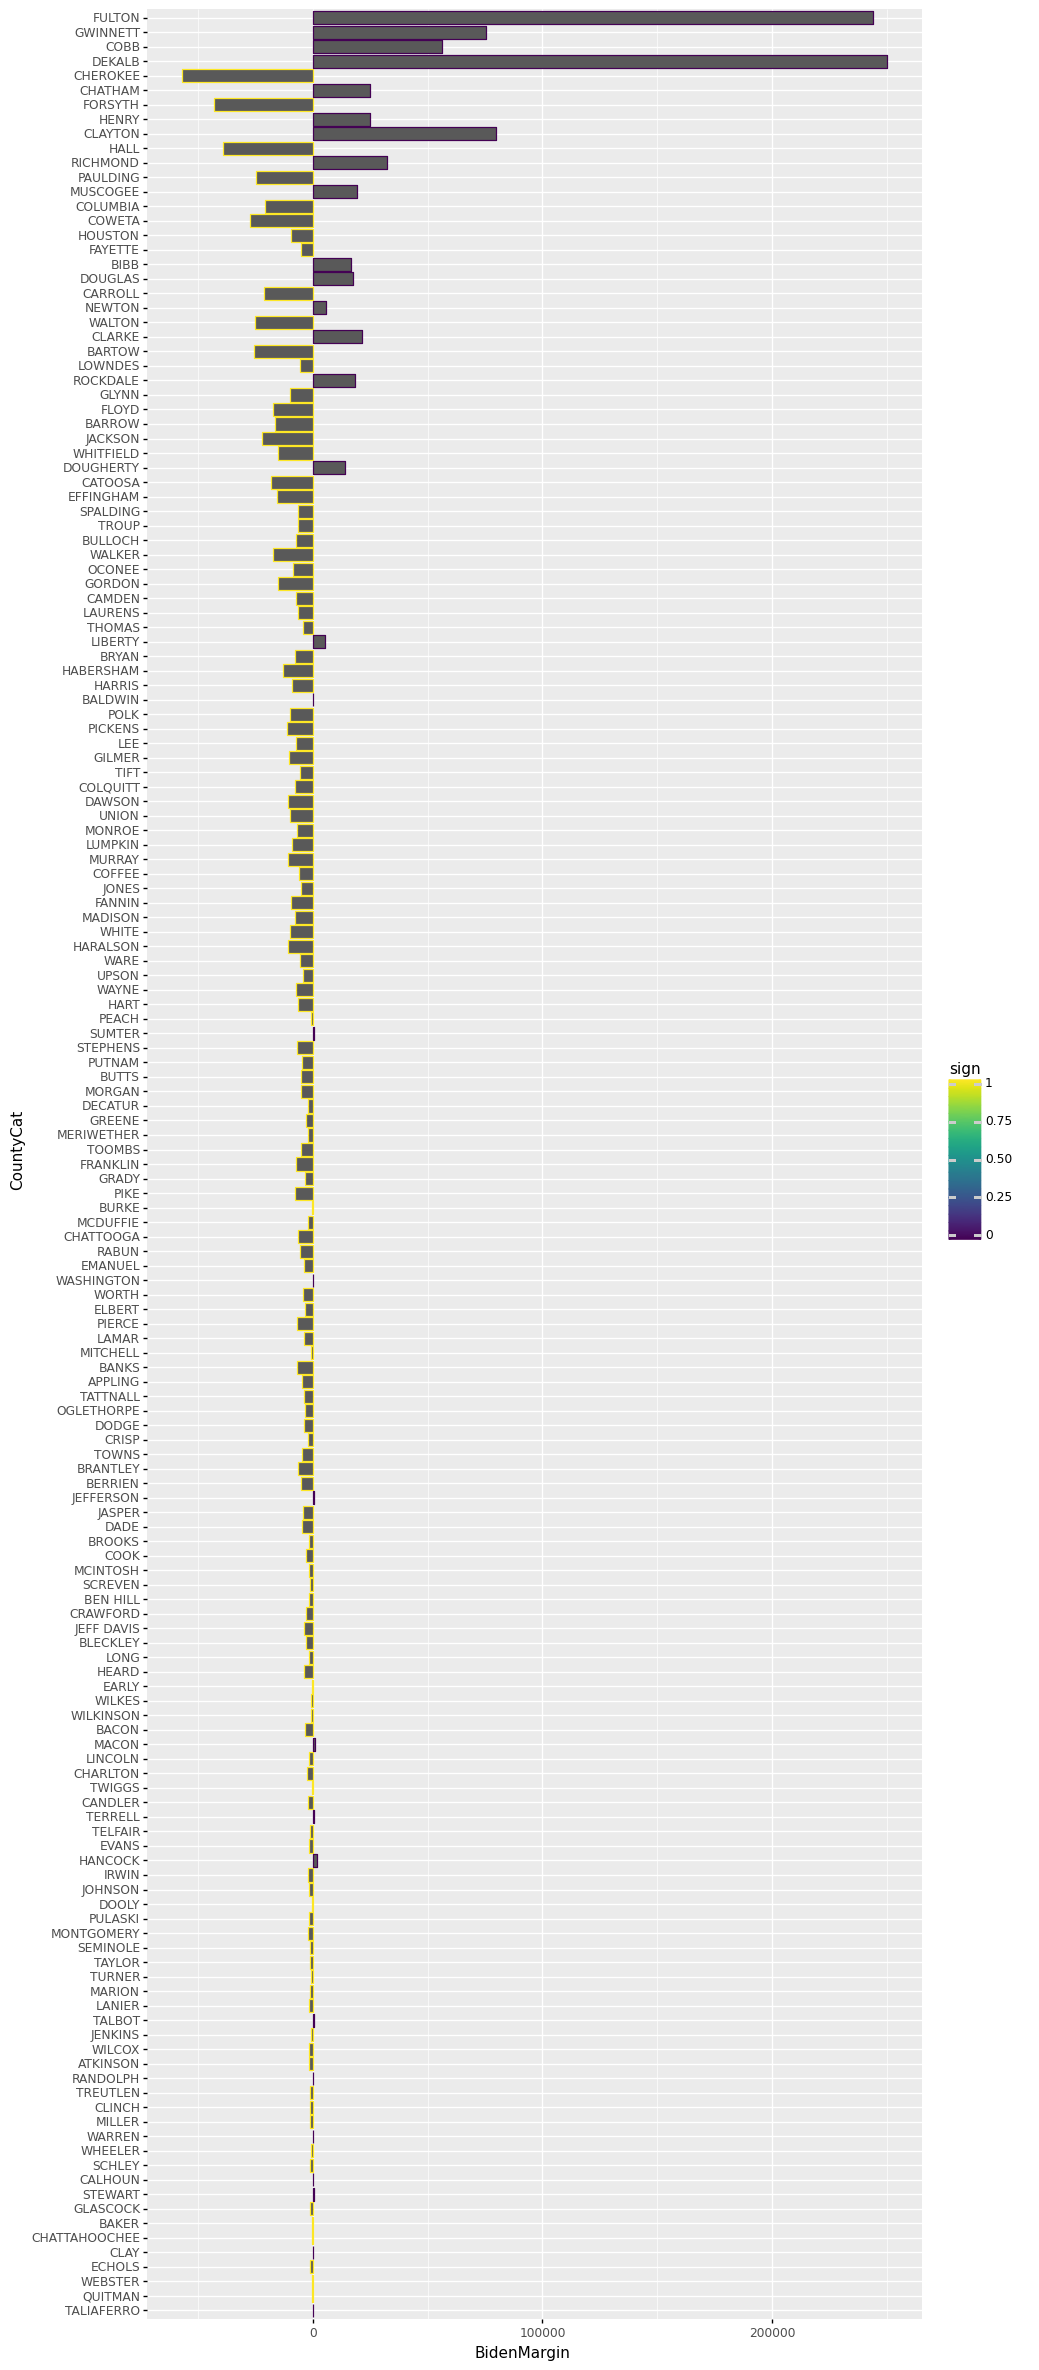

<ggplot: (176799336623)>

In [68]:
import plotnine as pn
from plotnine import ggplot, geom_point, geom_bar, aes, stat_smooth, facet_wrap


pn.options.figure_size = (10, 30)
(ggplot(z) 
+ pn.coord_flip()
+ geom_bar(aes(x='CountyCat', y='BidenMargin',color="sign"), stat='identity'))